In [88]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import dates
from matplotlib.legend_handler import HandlerLine2D
from mpl_toolkits.mplot3d import Axes3D
from netCDF4 import num2date,date2num,Dataset
from scipy.stats import pearsonr
import scipy,matplotlib
import skimage.measure as skm
import pyart
import copy
import sys
import os, subprocess, time
import pyproj
from mpl_toolkits.basemap import Basemap
from joblib import Parallel, delayed
import datetime
import mahotas,pymorph,pylab
import scipy.ndimage as ndi
import pandas as pd
import cPickle as pickle
import matplotlib.gridspec as gridspec
from marcus_py_tools import haversine,find_stuff_at_level,walklevel,latlon_from_xy,xy_from_latlon,make_edge_vec
%matplotlib inline

# Test Spatial Statistics
July 15 2016 - this serves as a testbed for quantifying the spatial organization of convective cells in groupings of thunderstorms, e.g. in MCS or whatever. Multiple tests will be made to see how well each metric quantifies what we're looking for. What are we looking for? 
- Spacing of cells (nearest neighbor?)
- Number of cells (spatial density within convective region?)
- How wide is the line (???)

The first has been coded and tested. The second requires implementation of some convective/stratiform partition code. This can be adapted from pre-existing code, or coded fresh. The third will require some experimentation

## How wide is the line?
We will play around with a distance transform applied to identified KDP columns or updraft features.

In [10]:
zhhnm     = 'reflectivity'
zdrnm     = 'differential_reflectivity'
kdpnm     = 'kdp'
rhonm     = 'cross_correlation_ratio'
zaxnm     = 'z_disp'
hfmt = dates.DateFormatter('%H:%M')
zsfc = 340.

In [6]:
filepath = '/home/mvanlier/mvanlier/nexrad_kvnx_520/'
filepre = 'grid2'
#..Get list of files
radfiles = []
numfiles = 0
epocs = []
for root,dirs,files in walklevel(filepath,level=0):
    for file in files:
        if file.startswith(filepre):
            radfiles.append(file)
            numfiles +=1
radfiles = sorted(radfiles)
print 'numfiles=',numfiles
print radfiles[60]

numfiles= 150
grid2_kvnx20110520_102327.nc


In [26]:
filenm = radfiles[55]
#..Load data, look at it
epoc  = (datetime.datetime(int(filenm[-18:-14]),int(filenm[-14:-12]),int(filenm[-12:-10]),
                               int(filenm[-9:-7]),int(filenm[-7:-5]),int(filenm[-5:-3])) -
             datetime.datetime(1970,1,1)).total_seconds()
#..Load data from file
nc = Dataset(filepath+filenm,'r')
xd = nc.variables['x_disp'][:]
yd = nc.variables['y_disp'][:]
zd = nc.variables[zaxnm][:]
alt= zd + zsfc
xgrid = np.tile(xd,(len(yd),1))
ygrid = np.tile(yd,(len(xd),1))
ygrid = ygrid.T
zhh = nc.variables[zhhnm][0,:,:,:]
zdr = nc.variables[zdrnm][0,:,:,:]
kdp = nc.variables[kdpnm][0,:,:,:]
rho = nc.variables[rhonm][0,:,:,:]
nc.close()

3960.68965517


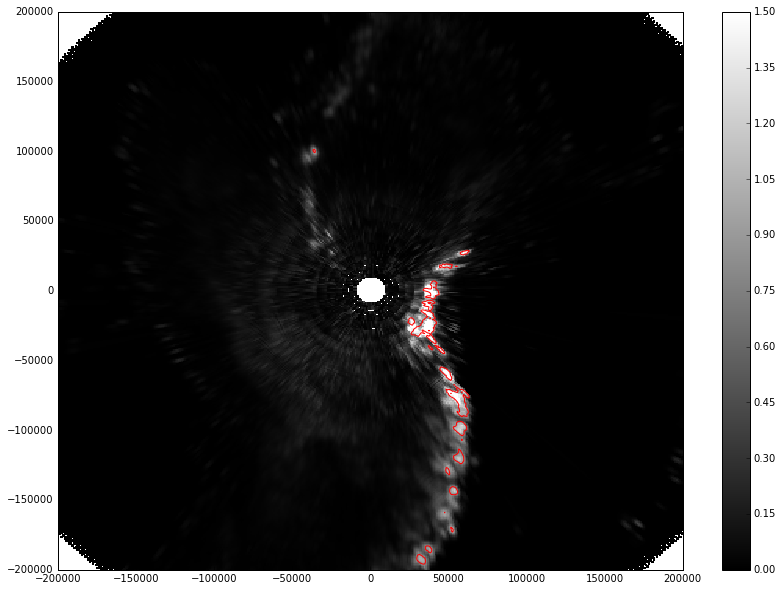

In [30]:
lev=7
fig = plt.figure(figsize=(14,10))
ab=plt.pcolormesh(xd,yd,kdp[lev,:,:],cmap=cm.gray,vmin=0,vmax=1.5)
plt.contour(xd,yd,kdp[8,:,:],levels=[0.75,],colors=['r',])
plt.colorbar(ab)
#..
print alt[lev]
#..

As can be seen, the convective line, as defined by KDP, is very narrow. Let's pick out the KDP columns and then play around with the distance transform

In [35]:
threshold=4.5
blurval=0.9
leveloff=1
levelup=6
leveldown=0
kdpthr=.75
altmelt = 3900.

meltlev = min(range(len(alt)),key=lambda i:abs(alt[i]-altmelt))
print meltlev
#..Find the kdp objects of interest
kdp_proc = copy.deepcopy(kdp)
kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
#     kdp_proc = np.ma.masked_where(rho<.8,kdp_proc)
#     kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
#..Get KDP objects
kdp_seeds,nobj,kdpi,kdpif,kdp_obj = find_stuff_at_level(kdp_proc,meltlev,threshold,blurval,
                                                       leveloff  = leveloff,
                                                       levelup   = levelup,
                                                       leveldown = leveldown,
                                                       debug     = True,
                                                       newseg    = True,erodedilate = False)

7


11


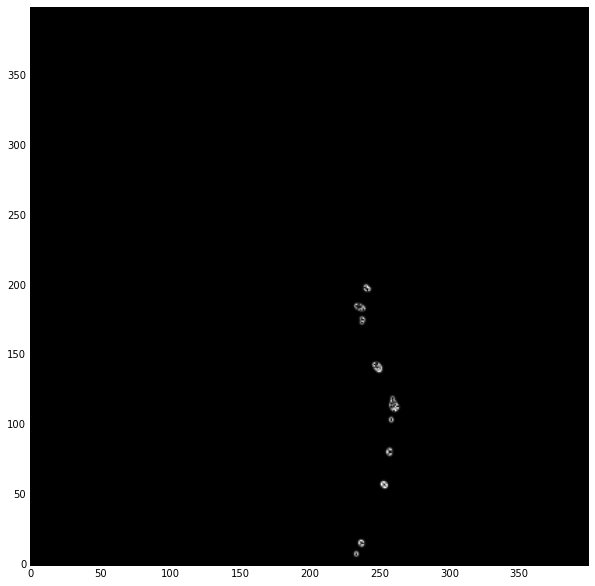

In [34]:
rmax = copy.deepcopy(kdp_seeds)
rmax[rmax>1]=1
fig = plt.figure(figsize=(14,10))
pylab.imshow(pymorph.overlay(kdpif,rmax),origin='lower')
print nobj

In [55]:
objst = copy.deepcopy(kdp_seeds)
objst[kdp_seeds==0]=1
objst[kdp_seeds>0]=False
dmap = np.sqrt(mahotas.distance(objst))

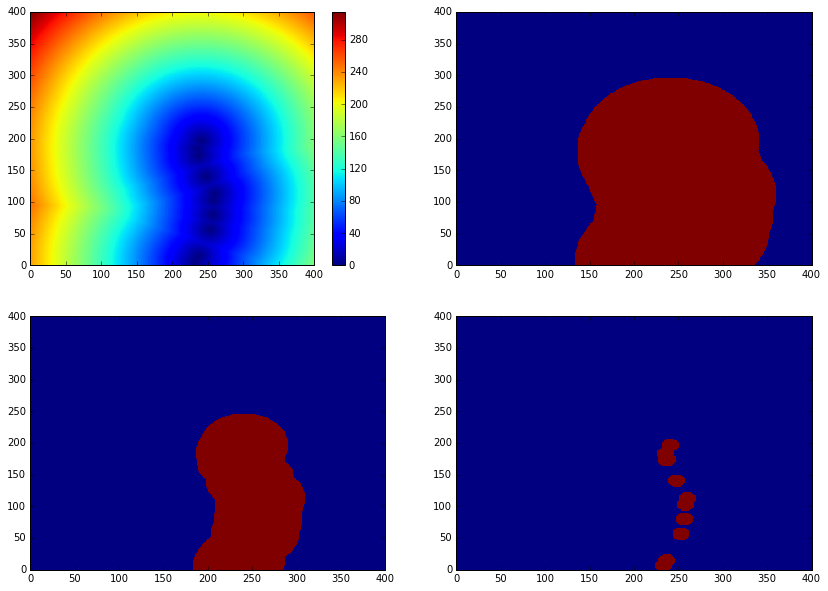

In [58]:
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
ab=ax1.pcolormesh(dmap)
plt.colorbar(ab)
ax2 = fig.add_subplot(2,2,2)
ax2.pcolormesh(dmap<100.)
ax3 = fig.add_subplot(2,2,3)
ax3.pcolormesh(dmap<50.)
ax4 = fig.add_subplot(2,2,4)
ax4.pcolormesh(dmap<10.)

In [63]:
#...Cacalate how area and perimeter of the enclosed region scale with distance
darr = np.linspace(1.,100.,num=100)
darea = []
dperm = []
for i in xrange(darr.shape[0]):
    dum = dmap<darr[i]
    darea = np.r_[darea,dum.sum()]
    dperm = np.r_[dperm,skm.perimeter(dum)]

In [71]:
#..Now try this with a shifted array (you'll see what I mean)
kdps2 = np.roll(kdp_seeds,25,axis=1) + kdp_seeds
objst2 = copy.deepcopy(kdps2)
objst2[kdps2==0]=1
objst2[kdps2>0]=False
dmap2 = np.sqrt(mahotas.distance(objst2))

In [75]:
#..Now try this with a shifted array (you'll see what I mean)
kdps3 = np.roll(kdp_seeds,45,axis=1)+np.roll(kdp_seeds,25,axis=1) + kdp_seeds
objst3 = copy.deepcopy(kdps3)
objst3[kdps3==0]=1
objst3[kdps3>0]=False
dmap3 = np.sqrt(mahotas.distance(objst3))

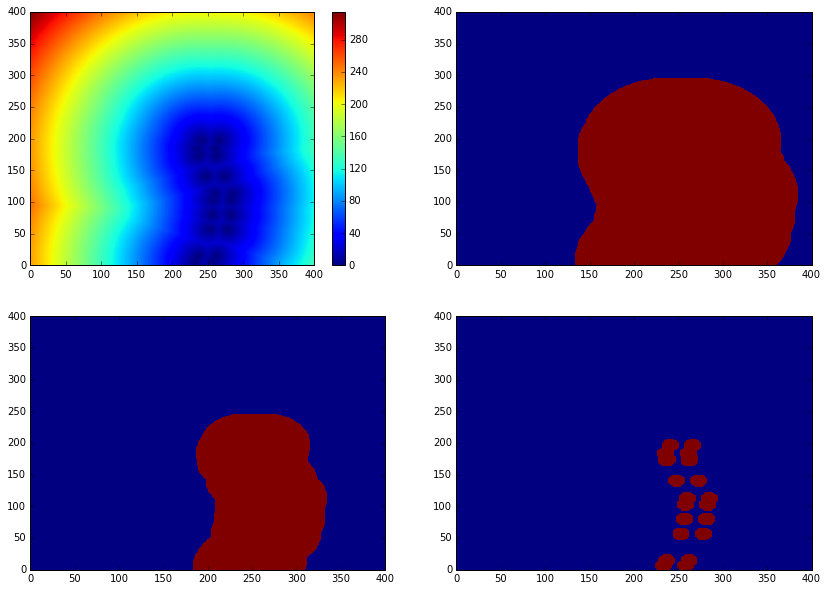

In [72]:
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
ab=ax1.pcolormesh(dmap2)
plt.colorbar(ab)
ax2 = fig.add_subplot(2,2,2)
ax2.pcolormesh(dmap2<100.)
ax3 = fig.add_subplot(2,2,3)
ax3.pcolormesh(dmap2<50.)
ax4 = fig.add_subplot(2,2,4)
ax4.pcolormesh(dmap2<10.)

In [73]:
#...Cacalate how area and perimeter of the enclosed region scale with distance
#darr = np.linspace(1.,100.,num=100)
darea2 = []
dperm2 = []
for i in xrange(darr.shape[0]):
    dum = dmap2<darr[i]
    darea2 = np.r_[darea2,dum.sum()]
    dperm2 = np.r_[dperm2,skm.perimeter(dum)]

In [76]:
#...Cacalate how area and perimeter of the enclosed region scale with distance
#darr = np.linspace(1.,100.,num=100)
darea3 = []
dperm3 = []
for i in xrange(darr.shape[0]):
    dum = dmap3<darr[i]
    darea3 = np.r_[darea3,dum.sum()]
    dperm3 = np.r_[dperm3,skm.perimeter(dum)]

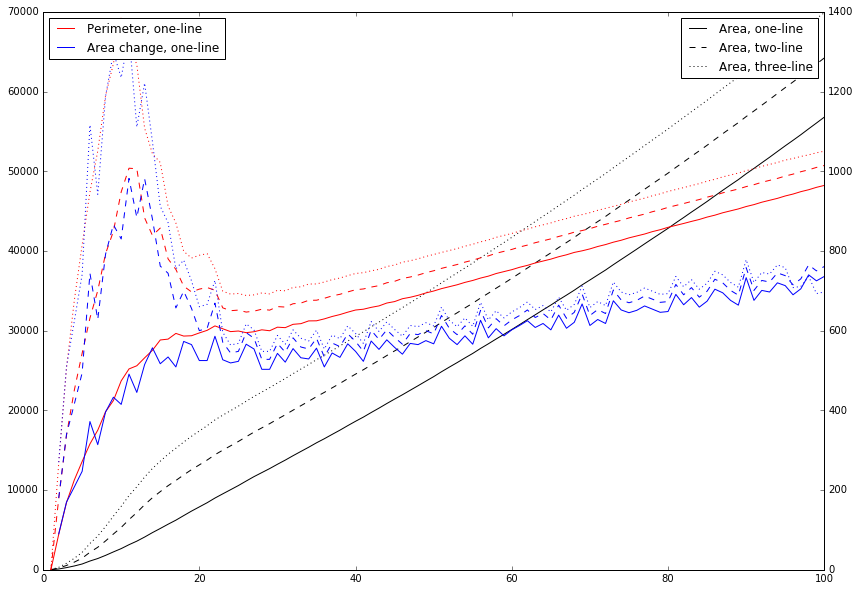

In [84]:
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(darr,darea,'k',label='Area, one-line')
ax1.plot(darr,darea2,'k--',label='Area, two-line')
ax1.plot(darr,darea3,'k:',label='Area, three-line')
plt.legend()
ax2 = ax1.twinx()
ax2.plot(darr,dperm,'r',label='Perimeter, one-line')
ax2.plot(darr,dperm2,'r--')
ax2.plot(darr,dperm3,'r:')
#..
ax2.plot(darr[1:],darea[1:]-darea[0:-1],'b',label='Area change, one-line')
ax2.plot(darr[1:],darea2[1:]-darea2[0:-1],'b--')
ax2.plot(darr[1:],darea3[1:]-darea3[0:-1],'b:')
#..
plt.legend(loc=2)
#..

## Conclusions
Extrapolating wildly based on this one, very limited, example, we can conclude the following:
1. The initial rate of increase in perimeter is driven by the number of objects present
2. A local maximum perimeter occurs at the point just before objects begin to join
3. Perimeter then drops in cases with "bunched" objects, whereas less of a drop is observed in cases with linear objects
4. The subsequent increase in perimeter happens at a much reduced rate, slowly increasing to be equal to rate of increase in distance threshold
5. Changes in area are less dramatic, but...
6. Rate of area change match very closely perimeter change!

There are severe limitations to this analysis, mostly that the lines we use here are synthetically separated by some set distance, which is manifestly not the case for "real" cells. However, this analysis may still give an important sense for how cells are spatially distributed. Maybe we'll see...

## Now, weaponize this!
Now, loop over all radar times, and do this analysis. Let's see how this analysis evolves in time -- can we see evidence for organization/clustering??

In [109]:
#..Loop over all radar files
threshold=4.5
blurval=0.9
leveloff=1
levelup=6
leveldown=0
kdpthr=.75
altmelt = 3900.

epocs = []
for j in xrange(numfiles):
    print j,
    filenm = radfiles[j]
    #..Load data, look at it
    epoc  = (datetime.datetime(int(filenm[-18:-14]),int(filenm[-14:-12]),int(filenm[-12:-10]),
                                   int(filenm[-9:-7]),int(filenm[-7:-5]),int(filenm[-5:-3])) -
                 datetime.datetime(1970,1,1)).total_seconds()
    epocs = np.r_[epocs,epoc]
    #..Load data from file
    nc = Dataset(filepath+filenm,'r')
    xd = nc.variables['x_disp'][:]
    yd = nc.variables['y_disp'][:]
    zd = nc.variables[zaxnm][:]
    alt= zd + zsfc
    xgrid = np.tile(xd,(len(yd),1))
    ygrid = np.tile(yd,(len(xd),1))
    ygrid = ygrid.T
    zhh = nc.variables[zhhnm][0,:,:,:]
    zdr = nc.variables[zdrnm][0,:,:,:]
    kdp = nc.variables[kdpnm][0,:,:,:]
    rho = nc.variables[rhonm][0,:,:,:]
    nc.close()

    meltlev = min(range(len(alt)),key=lambda i:abs(alt[i]-altmelt))
    #print meltlev
    #..Find the kdp objects of interest
    kdp_proc = copy.deepcopy(kdp)
    kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
    #     kdp_proc = np.ma.masked_where(rho<.8,kdp_proc)
    #     kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
    #..Get KDP objects
    kdp_seeds,nobj,kdpi,kdpif,kdp_obj = find_stuff_at_level(kdp_proc,meltlev,threshold,blurval,
                                                           leveloff  = leveloff,
                                                           levelup   = levelup,
                                                           leveldown = leveldown,
                                                           debug     = True,
                                                           newseg    = True,erodedilate = False)
    #..
    objst = copy.deepcopy(kdp_seeds)
    objst[kdp_seeds==0]=1
    objst[kdp_seeds>0]=False
    dmap = np.sqrt(mahotas.distance(objst))
    #..
    #...Cacalate how area and perimeter of the enclosed region scale with distance
    darr = np.linspace(1.,100.,num=100)
    darea = []
    dperm = []
    for i in xrange(darr.shape[0]):
        dum = dmap<darr[i]
        darea = np.r_[darea,dum.sum()]
        dperm = np.r_[dperm,skm.perimeter(dum)]
    if (j!=0):
        darea_all = np.vstack((darea_all,darea))
        dperm_all = np.vstack((dperm_all,dperm))
    else:
        darea_all = darea
        dperm_all = dperm
    #..

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149


(150, 100)


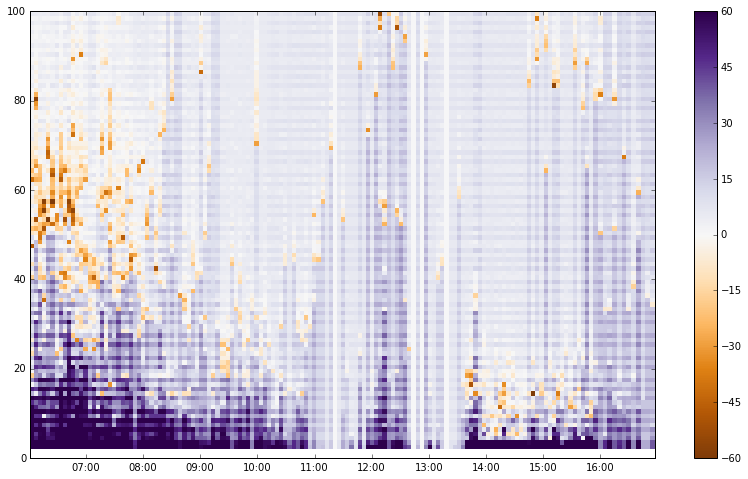

In [120]:
dts = map(datetime.datetime.utcfromtimestamp,epocs)
tim = dates.date2num(dts)
#..Time "edges" rather than centers
tme = make_edge_vec(tim)
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(1,1,1)
print dperm_all.shape
#plt.pcolormesh(dperm_all.T)
#plt.pcolormesh(tim,darr,darea_all.T,cmap=cm.gist_stern)
#plt.pcolormesh(tim,darr[1:],darea_all[:,1:].T-darea_all[:,0:-1].T,cmap=cm.gist_stern)
#plt.pcolormesh(tim,darr,dperm_all.T,cmap=cm.gist_stern)
plt.pcolormesh(tim,darr[1:],dperm_all[:,1:].T-dperm_all[:,0:-1].T,vmin=-60,vmax=60,cmap=cm.PuOr)
ax1.xaxis.set_major_locator(dates.HourLocator())
ax1.xaxis.set_major_formatter(hfmt)
ax1.set_xlim(tim[0],tim[-1])
plt.colorbar()

### Conclusions based on analysis of radar? 
 1. Signal is going to be hard to find (unless this is obviously different from analysis of NU-WRF)
 2. There are differences between disorganized period (say, before 9) and organized (after), but its hard to see..
 3. area change with dthresh vs dthresh looks similar to perimeter vs dthresh (we kinda knew that)
 4. perimeter change with dthresh may be the best signal, but we have to look at model data...
 
## Model data analysis below!

In [130]:
print wrf_files[60]

wrfout_d03_2011-05-20_10:00:00


In [136]:
#..First, make an index of all radar times
#..
basepath  = '/mnt/raid/afridlin/data/mc3e/nu-wrf-bulk/NU-WRF_MC3E_2011-05-20_morrison/'
wrf_files = []
numfiles  = 0
epocs = []
for root,dirs,files in walklevel(basepath,level=0):
    for file in files:
        if file.endswith(':00'):
            wrf_files.append(file)
            numfiles += 1
            wrf_epoc = (datetime.datetime(2011,5,int(file[-11:-9]),int(file[-8:-6]),int(file[-5:-3])) -
                        datetime.datetime(1970,1,1)).total_seconds()
            epocs = np.r_[epocs,wrf_epoc]
wrf_files = sorted(wrf_files)
epocs = sorted(epocs)
#..
u_nm = 'U'     #..(Time, bottom_top, south_north, west_east_stag)
v_nm = 'V'     #..(Time, bottom_top, south_north_stag, west_east)
w_nm = 'W'     #..(Time, bottom_top_stag, south_north, west_east)
w_up_nm = 'W_UP_MAX' #..(Time, south_north, west_east)
#..
ulon_nm = 'XLONG_U'  #..(Time, south_north, west_east_stag)
ulat_nm = 'XLAT_U'   #..(Time, south_north, west_east_stag)
vlon_nm = 'XLONG_V'  #..(Time, south_north_stag, west_east)
vlat_nm = 'XLAT_V'   #..(Time, south_north_stag, west_east)
lon_nm  = 'XLONG'    #..(Time, south_north, west_east)
lat_nm  = 'XLAT'     #..(Time, south_north, west_east)
tim_nm  = 'XTIME'    #..(Time)
etau_nm = 'ZNU'      #..(Tme, bottom_top)
etaw_nm = 'ZNW'      #..(Time, bottom_top_stag)
qrain_nm = 'QRAIN'   #..(Time, bottom_top, sourth_north, west_east)
#..
ref_nm  = 'REFL_10CM'#..(Time, bottom_top, south_north, west_east)
rsed_nm = 'PRECR3D'  #..(Time, bottom_top, south_north, west_east)
#..
ppres_nm = 'P'       #..(Time, bottom_top, south_north, west_east)
bpres_nm = 'PB'      #..(Time, bottom_top, south_north, west_east)
pthet_nm = 'T'       #..(Time, bottom_top, south_north, west_east)
#..
kvnx_lat =  36.737
kvnx_lon = -98.124
#..

In [134]:
#..Get height of levels using PH and PHB (hybrid sigma-eta, etc..)
filenm = wrf_files[60]
nc = Dataset(basepath+filenm,'r')
ph = nc.variables['PH'][0,:,:,:]
phb = nc.variables['PHB'][0,:,:,:]
zw = (ph+phb)/9.81
lon = nc.variables[lon_nm][0,:,:]
lat = nc.variables[lat_nm][0,:,:]
nc.close()
#..

#..get a representative time of updraft
filenm = wrf_files[60]
nc = Dataset(basepath+filenm,'r')
wup = nc.variables[w_nm][0,:,:,:]
nc.close()

dd = np.ma.masked_where(np.logical_or(zw>9000.,zw<6000.),wup)

wup_avg = dd.mean(axis=0)
print wup_avg.shape
threshold = 15.
blurval = 1.
upd_seeds,nobj,updi,updif,upd_obj = find_stuff_at_level(wup_avg,16,threshold,blurval,
                                                        leveloff  = 0,
                                                        levelup   = 4,
                                                        leveldown = 0,
                                                        debug     = True,
                                                        erodedilate = False,
                                                        newseg    = False,
                                                        twodim_field = True)

(534, 789)


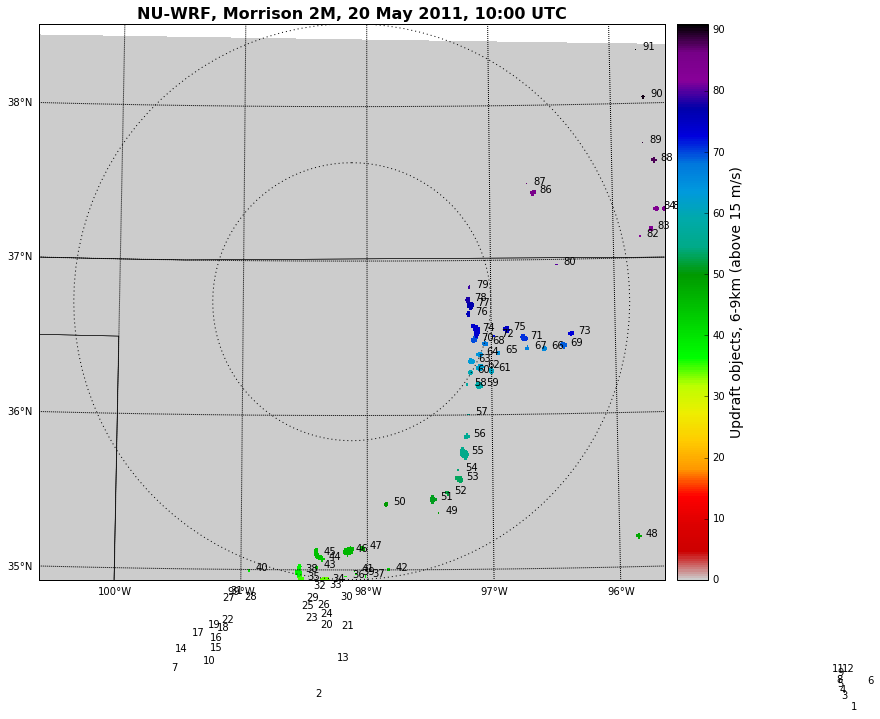

In [137]:
fig = plt.figure(figsize=(12,10))
#..Get a list of kdp object x,y positions
lon_kdp = []
lat_kdp = []
for i in range(nobj):
    lon_kdp = np.r_[lon_kdp,lon[upd_obj==i+1].mean()]
    lat_kdp = np.r_[lat_kdp,lat[upd_obj==i+1].mean()]
#print lon_kdp
#..
m = Basemap(width=450000.,height=400000,projection='lcc',resolution='i',
            lon_0=kvnx_lon,lat_0=kvnx_lat,lat_1=33.,lat_2=39.)
parallels = np.arange(33.,40.,1.)
meridians = np.arange(259.,273.,1.)
m.drawstates(color='k')
m.drawparallels(parallels,color='k',labels=[True,False,False,False])
m.drawmeridians(meridians,color='k',labels=[False,False,False,True])
m.tissot(kvnx_lon,kvnx_lat,54./60.,100,edgecolor='k',facecolor='none',ls='dotted')
m.tissot(kvnx_lon,kvnx_lat,108./60.,100,edgecolor='k',facecolor='none',ls='dotted')
#..
#im1 = m.pcolormesh(ulon,ulat,w_up_max,cmap=cm.CMRmap,latlon=True,vmin=1.)
dd = np.ma.masked_where(np.logical_or(zw>9000.,zw<6000.),wup)
im1 = m.pcolormesh(lon,lat,upd_obj,cmap=cm.spectral_r,latlon=True)
for i in range(nobj):
    x,y = m(lon_kdp[i],lat_kdp[i])
    plt.text(x+5000.,y,str(i+1))
cb = m.colorbar()
cb.set_label('Updraft objects, 6-9km (above 15 m/s)',fontsize=14)
plt.title('NU-WRF, Morrison 2M, 20 May 2011, '+filenm[-8:-3]+' UTC',fontsize=16,fontweight='bold')

In [139]:
#..Let's do the same thing we did for radar, now for model updrafts
threshold = 15.
blurval = 1.

epocz = []
for j in xrange(numfiles):
    print j,
    filenm = wrf_files[j]
    #..Load data, look at it
    wrf_epoc = (datetime.datetime(2011,5,int(filenm[-11:-9]),int(filenm[-8:-6]),int(filenm[-5:-3])) -
                        datetime.datetime(1970,1,1)).total_seconds()
    epocz = np.r_[epocz,wrf_epoc]

    #..get a representative time of updraft
    nc = Dataset(basepath+filenm,'r')
    wup = nc.variables[w_nm][0,:,:,:]
    nc.close()
    dd = np.ma.masked_where(np.logical_or(zw>9000.,zw<6000.),wup)
    wup_avg = dd.mean(axis=0)
    
    #     kdp_proc = np.ma.masked_where(rho<.8,kdp_proc)
    #     kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
    #..Get KDP objects
    upd_seeds,nobj,updi,updif,upd_obj = find_stuff_at_level(wup_avg,16,threshold,blurval,
                                                        leveloff  = 0,
                                                        levelup   = 4,
                                                        leveldown = 0,
                                                        debug     = True,
                                                        erodedilate = False,
                                                        newseg    = False,
                                                        twodim_field = True)
    #..
    objst = copy.deepcopy(upd_seeds)
    objst[upd_seeds==0]=1
    objst[upd_seeds>0]=False
    dmap = np.sqrt(mahotas.distance(objst))
    #..
    #...Cacalate how area and perimeter of the enclosed region scale with distance
    darr = np.linspace(1.,100.,num=100)
    darea = []
    dperm = []
    for i in xrange(darr.shape[0]):
        dum = dmap<darr[i]
        darea = np.r_[darea,dum.sum()]
        dperm = np.r_[dperm,skm.perimeter(dum)]
    if (j!=0):
        darea_all_m = np.vstack((darea_all,darea))
        dperm_all_m = np.vstack((dperm_all,dperm))
    else:
        darea_all_m = darea
        dperm_all_m = dperm
    #..

 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164


In [142]:
print numfiles

165


(151, 100)


TypeError: Dimensions of C (99, 151) are incompatible with X (165) and/or Y (99); see help(pcolormesh)

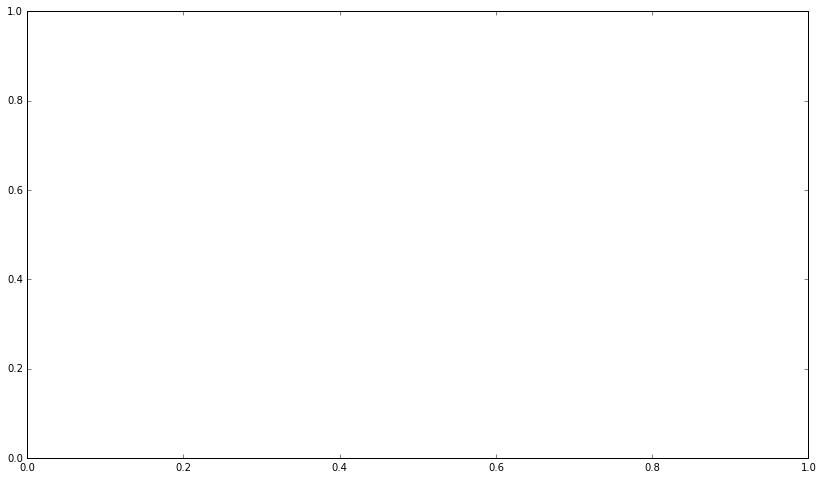

In [141]:
dts = map(datetime.datetime.utcfromtimestamp,epocz)
tim = dates.date2num(dts)
#..Time "edges" rather than centers
tme = make_edge_vec(tim)
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(1,1,1)
print dperm_all_m.shape
#plt.pcolormesh(dperm_all.T)
#plt.pcolormesh(tim,darr,darea_all.T,cmap=cm.gist_stern)
#plt.pcolormesh(tim,darr[1:],darea_all[:,1:].T-darea_all[:,0:-1].T,cmap=cm.gist_stern)
#plt.pcolormesh(tim,darr,dperm_all.T,cmap=cm.gist_stern)
plt.pcolormesh(tim,darr[1:],dperm_all_m[:,1:].T-dperm_all_m[:,0:-1].T,vmin=-60,vmax=60,cmap=cm.PuOr)
ax1.xaxis.set_major_locator(dates.HourLocator())
ax1.xaxis.set_major_formatter(hfmt)
ax1.set_xlim(tim[0],tim[-1])
plt.colorbar()

## Another approach:
Another approach is to consider the nearest-neighbor distribution. For each tracked object, count the number of objects within mode(nndist)+/-std(nndist). For a linear system, this should be ~2. For a sytem that has multiple lines, or some such, this will be >2, because the other cell elements will be found by this search. 

# JUNKY STUFF BELOW ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

In [38]:
def normalize_array(array_in,minval=0,maxval=255,integerout=True,invert=False):
    array_out = copy.deepcopy(array_in)
    array_out[array_out<0.] = 0.  #..Here is subzero, now plain zero
    #..we lazily assume the minimum is zero...
    array_out = maxval*array_out/(array_out.max())
    if integerout:
        array_out = array_out.astype(np.uint8)
    if invert:
        array_out = maxval-array_out
    return array_out

In [39]:
zgrid = np.zeros((len(zd),len(yd),len(xd)))
for j in range(len(zd)):
    zgrid[j,:,:] = zd[j]
kdp_proc = copy.deepcopy(kdp)
kdp_proc[rho<.8] = 0.
kdp_proc[zhh<15.] = 0.
kdp_proc[kdp_proc==-9999.] = 0.
#kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
#kdp_proc = np.ma.masked_where(rho<.8,kdp_proc)
#kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
#kdp_proc = np.ma.masked_where(zhh<20.,kdp_proc)
#kdp_int = kdp_proc[9:15,:,:].sum(axis=0)

vol_ones = kdp_proc*0.+1
kdp_pet = (zgrid[8:16,:,:]*kdp_proc[8:16,:,:]).sum(axis=0)/vol_ones[8:16,:,:].sum(axis=0)
kdp_pet[kdp_pet>3000.]=3000.

kdp_pet_proc = normalize_array(kdp_pet,invert=True)

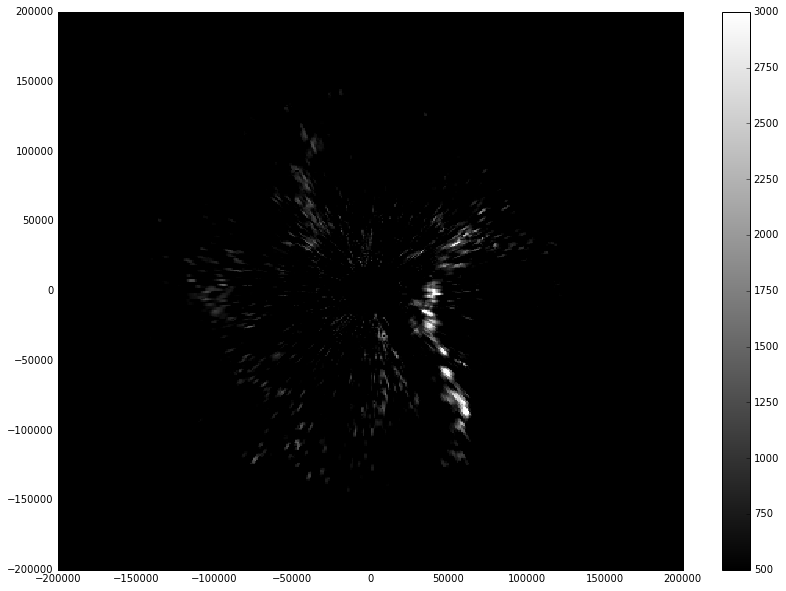

In [44]:
fig = plt.figure(figsize=(14,10))
plt.pcolormesh(xd,yd,kdp_pet,cmap=cm.gray,vmin=500,vmax=3000)
plt.colorbar()